# 2020-09-10 • STA for ≠ PSP shapes

This notebook builds on {doc}`/notebooks/2020-07-29__STA`.\
There, we cut out spike-triggered windows of a noisy VI signal, and averaged them, to obtain one STA (spike triggered average) window per incoming neuron. The STA windows from connected neurons [showed](https://tfiers.github.io/voltage-to-wiring-sim/notebooks/2020-07-29__STA.html#plot-average-windows-of-all-spike-trains)
a nice bump (at ~10 ms post spike) which made them well differentiable from those of unconnected neurons (which had flat STA windows, as expected).

The question is if this bump is due to averaging post synaptic potentials (PSPs), or postsynaptic spikes.

In this notebook we investigate that question by changing the PSP shape (by changing the synaptic integration time constant $\tau_{syn}$), and then checking whether the STA bump tracks this change in shape, or not.


## Imports & time grid

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading:
 - numpy … (0.33 s)
 - matplotlib.pyplot … (0.47 s)
 - numba … (0.80 s)
 - sympy … (0.97 s)
 - unyt … (2.38 s)

Imported `np`, `mpl`, `plt
Imported package `voltage_to_wiring_sim` as `v`
Imported `*` from `v.util` and from `v.units`
Setup autoreload


In [2]:
tg = v.TimeGrid(T=10 * minute, dt=0.1 * ms)

TimeGrid(T=Quantity(10 min, stored in s, float64), dt=Quantity(0.1 ms, stored in s, float64), N=unyt_quantity(6000000, '(dimensionless)'), t=Array([0 1.667E-06 3.333E-06 ... 10 10 10] min, stored in s, float64))

## Spike trains

'Network' definition.

In [3]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

Have all incoming neurons spike with the same mean frequency, for now.

In [4]:
f_spike = 20 * Hz

Quantity(20 Hz, stored in Hz, float64)

In [5]:
gen_st = v.generate_Poisson_spike_train

fix_rng_seed()

In [6]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)]

Wall time: 3 s


In [7]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected

Inspect a time excerpt..

In [8]:
time_slice = 1 * minute + [0, 1] * second

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice].in_units(second)

..of one presynaptic neuron:


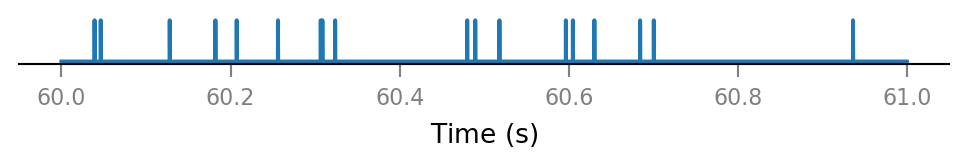

In [9]:
v.spike_train.plot(t_slice, all_spike_trains[0][i_slice])

All connected presynaptic neurons:

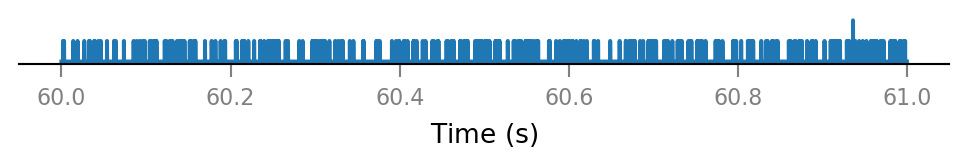

In [10]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice])

## Synaptic conductance

In [45]:
Δg_syn = 0.16 * nS
τ_syn = 35 * ms

Quantity(35 ms, stored in s, float64)

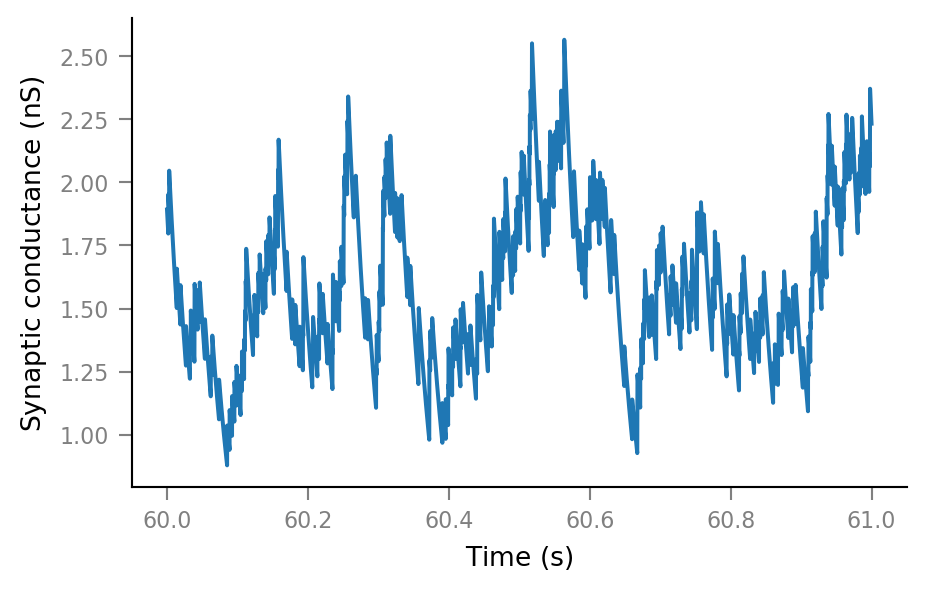

In [46]:
g_syn = v.calc_synaptic_conductance(tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice])

## Membrane voltage

In [47]:
params = v.params.cortical_RS
print(params)

IzhikevichParams
----------------
C = 100 pF
k = 0.7 nS/mV
v_r = -60 mV
v_t = -40 mV
v_peak = 35 mV
a = 0.03 1/ms
b = -2 nS
c = -50 mV
d = 100 pA
v_syn = 0 mV


In [48]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 588 ms


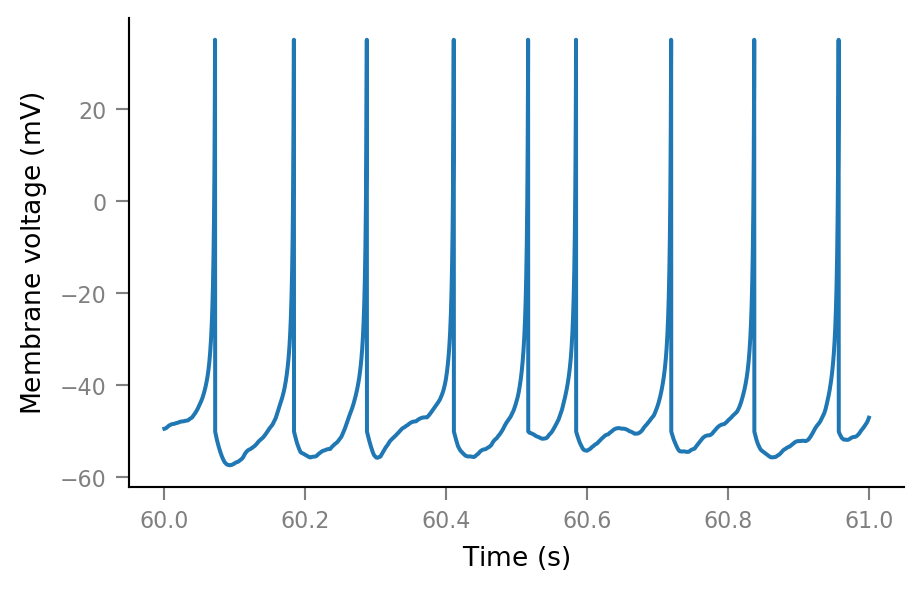

In [49]:
plt.plot(t_slice, sim.V_m[i_slice])

## Noise

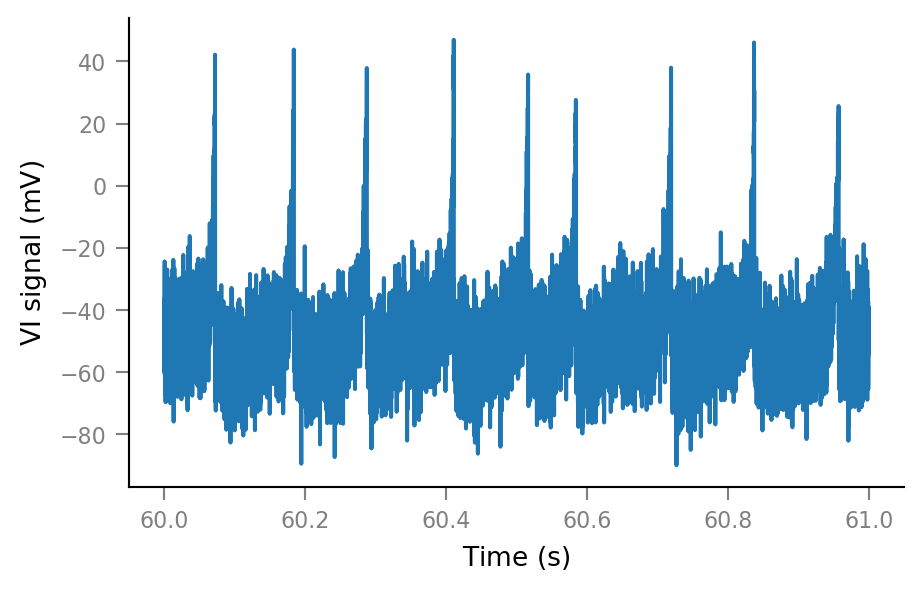

In [50]:
SNR = 10
spike_height = params.v_peak - params.v_r

σ_noise = spike_height / SNR
noise = np.random.randn(tg.N) * σ_noise

Vm_noisy = (sim.V_m + noise).in_units(mV)
Vm_noisy.name = "VI signal"

plt.plot(t_slice, Vm_noisy[i_slice])

## Spike-triggered windows

In [51]:
def get_spike_indices(spike_train):
    # `nonzero` returns a tuple (one element for each array dimension).
    (spike_indices,) = np.nonzero(spike_train)
    return spike_indices

Test with one spike train

In [52]:
spike_train__example = all_spike_trains[0]
spike_indices__example = get_spike_indices(spike_train__example)
num_spikes__example = len(spike_indices__example)
num_spikes__example

12020

Spiking frequency for this presynaptic neuron:

In [53]:
print(Quantity(num_spikes__example / tg.T, Hz))

20.03 Hz


Extract windows from the VI signal.

In [112]:
window_length = 100 * ms

window_tg = v.TimeGrid(window_length, tg.dt)
window_tg.t.name = "Time after spike"


# Performance
Vm_noisy_arr = np.asarray(Vm_noisy)
window_tg_N = window_tg.N
tg_N = tg.N

import numba

@numba.njit
def _make_windows(spike_indices):
    windows = []
    for ix in spike_indices:
        ix_end = ix + window_tg_N
        if ix_end < tg_N:
            windows.append(Vm_noisy_arr[ix:ix_end])

    return windows

def make_windows(spike_indices):
    windows = np.stack(_make_windows(spike_indices))
    return Array(windows, V, name=Vm_noisy.name).in_units(mV)

In [113]:
windows__example = make_windows(spike_indices__example)
windows__example.shape

(12019, 1000)

An example spike-triggered window:

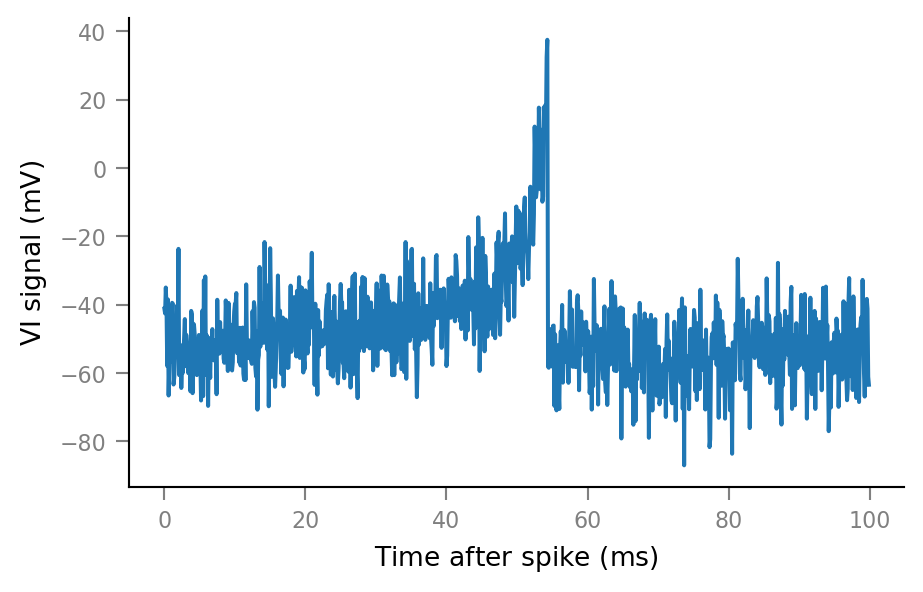

In [114]:
plt.plot(window_tg.t, windows__example[0, :])

And some more:

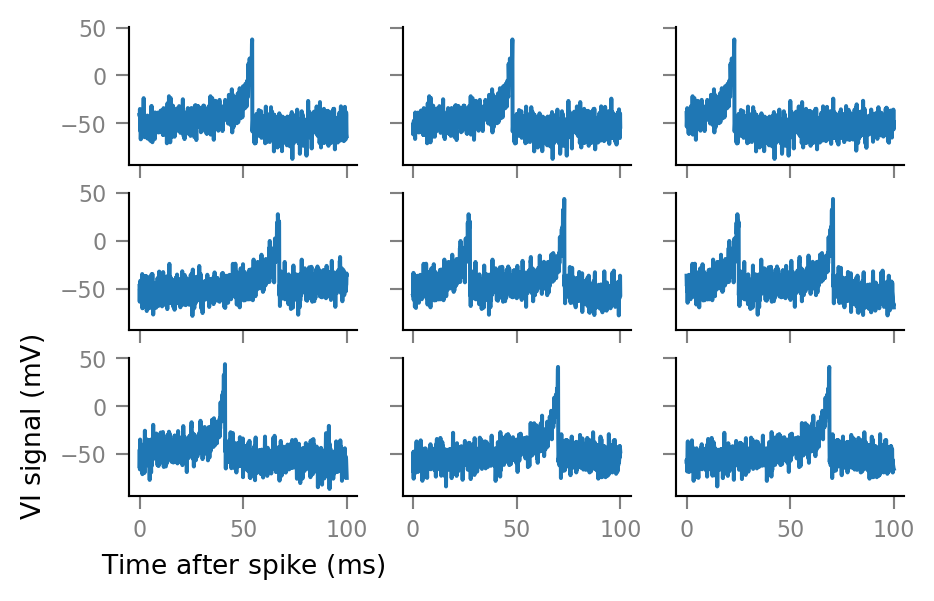

In [115]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        i = 3 * row + col
        ax.plot(window_tg.t, windows__example[i, :])
        if not (row == 2 and col == 0):
            ax.set(xlabel=None, ylabel=None)

## Average windows

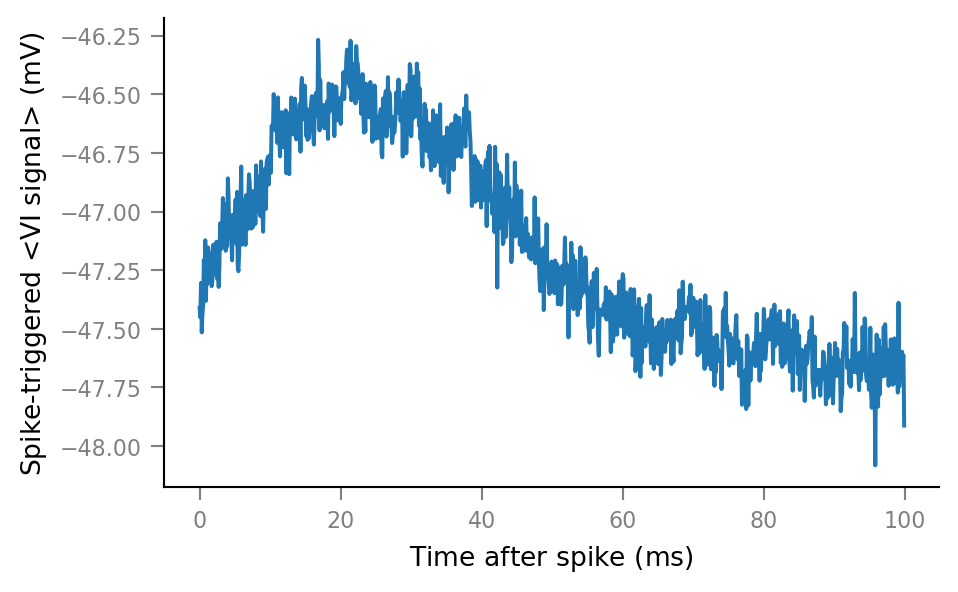

In [118]:
def STA(spike_train):
    spike_indices = get_spike_indices(spike_train)
    windows = make_windows(spike_indices)
    STA = windows.mean(axis=0)
    return Array(STA, V, name="Spike-triggered <VI signal>").in_units(mV)


def plot_STA(spike_train, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(window_tg.t, STA(spike_train), **kwargs)


plot_STA(spike_trains_connected[0])

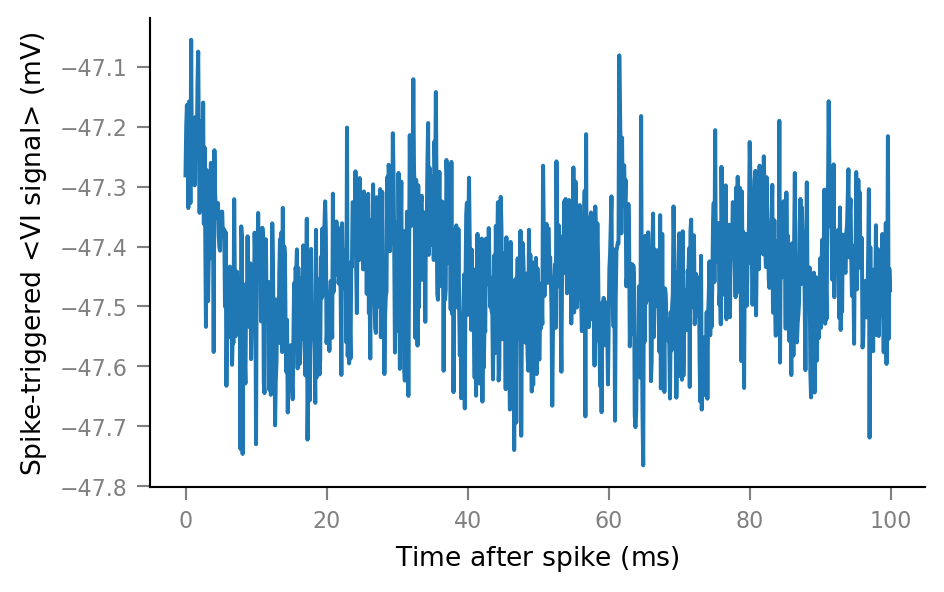

In [119]:
plot_STA(spike_trains_unconnected[0])

## Plot average windows of all spike trains

In [122]:
%%time

fig, ax = plt.subplots()

for spike_train in spike_trains_connected:
    plot_STA(spike_train, ax, alpha=0.2, color='C0')

for spike_train in spike_trains_unconnected:
    plot_STA(spike_train, ax, alpha=0.2, color='C1')
    
plt.close()

Wall time: 20.9 s


Extreme slowness is due to unyt.\
Hence I oughta use my own new yunit package, or use no unit package (plain NumPy arrays).

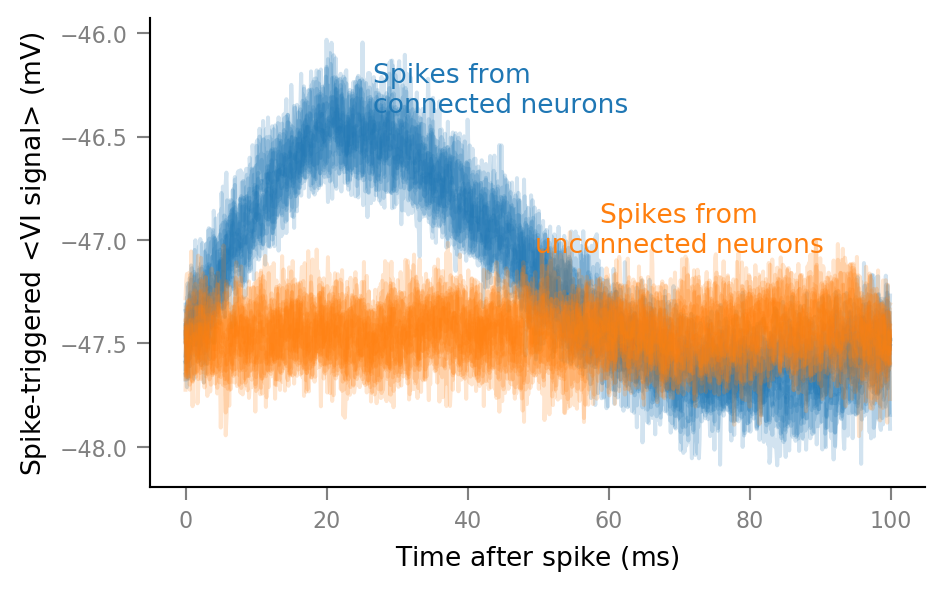

In [123]:
# Clear existing texts, for iterative positioning.
for _ in range(len(ax.texts)):
    ax.texts.pop()

ax.annotate(
    "Spikes from\nconnected neurons",
    xy=(26.55 * ms, 0.8),
    xycoords=("data", "axes fraction"),
    color="C0",
    ha="left",
)

ax.annotate(
    "Spikes from\nunconnected neurons",
    xy=(70 * ms, 0.5),
    xycoords=("data", "axes fraction"),
    color="C1",
    ha="center",
)

fig

Reminder of previous STA (with τ_syn = 7 ms):

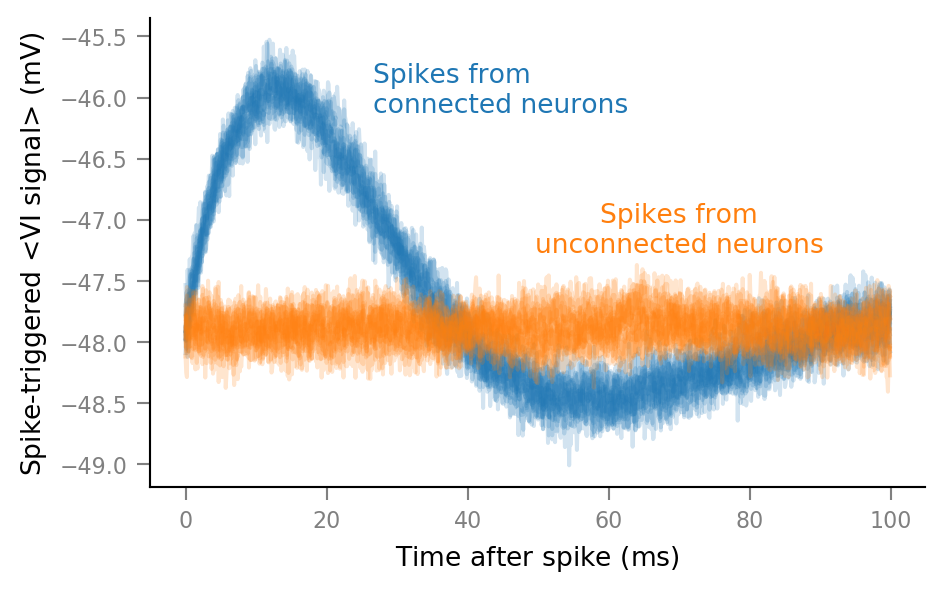

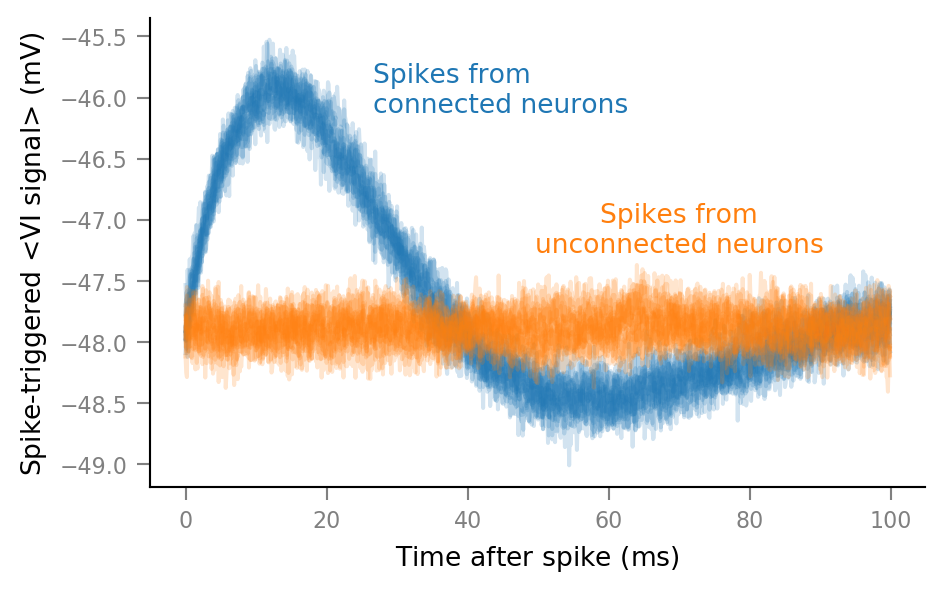

Next steps: 

New:
- bump could still be due to spikes. Maybe artifically clip spikes to lessen their influence on STA?

Existing:
- calculate p(connected) for every presynaptic neuron
- describe influence of `N_in`, `p_connected`, `SNR`, ..
- VI realism